# Detección de anomalías y Técnicas de agrupamiento

### Autor: Carles Serra Vendrell

## Importar librerías necesarias

In [56]:
# Calculo y manipulación de datos
import pandas as pd
import numpy as np

# Modelización
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

# Visualización
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

# Configurarciones
pd.set_option(
    "display.max_rows", 
    30, 
    "display.max_columns", 
    None)
pylab.rcParams['figure.figsize'] = (16.0, 7.0)

## Cargar dataset

In [3]:
data = pd.read_csv('/Users/carseven/dev/master-ai/machineLearning/lab3/creditcardcsvpresent.csv.xls')

## Análisis descritivo de los datos

### Analisis inicial y distinción de los tipos de variables

In [4]:
data.head(5)

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,NaN,100.0,3000.0,N,5,Y,Y,0,0.0,0,Y
1,3160040998,NaN,100.0,4300.0,N,5,Y,Y,0,0.0,0,Y
2,3160041896,NaN,185.5,4823.0,Y,5,N,N,0,0.0,0,Y
3,3160141996,NaN,185.5,5008.5,Y,8,N,N,0,0.0,0,Y
4,3160241992,NaN,500.0,26000.0,N,0,Y,Y,800,677.2,6,Y


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3075 entries, 0 to 3074
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Merchant_id                     3075 non-null   int64  
 1   Transaction date                0 non-null      float64
 2   Average Amount/transaction/day  3075 non-null   float64
 3   Transaction_amount              3075 non-null   float64
 4   Is declined                     3075 non-null   object 
 5   Total Number of declines/day    3075 non-null   int64  
 6   isForeignTransaction            3075 non-null   object 
 7   isHighRiskCountry               3075 non-null   object 
 8   Daily_chargeback_avg_amt        3075 non-null   int64  
 9   6_month_avg_chbk_amt            3075 non-null   float64
 10  6-month_chbk_freq               3075 non-null   int64  
 11  isFradulent                     3075 non-null   object 
dtypes: float64(4), int64(4), object(4)

El dataset se compone de 12 variables:
* Merchant_id
* Transaction date
* Average Amount/transaction/day
* Transaction_amount
* Is declined
* Total Number of declines/day
* isForeignTransaction
* isHighRiskCountry
* Daily_chargeback_avg_amt
* 6_month_avg_chbk_amt
* 6-month_chbk_freq
* isFradulent
Pequeña descripción de las columnas y borrar la columna de transaction date

Se ha decido eliminar la columna Trasaction date, puesto que se encuentra completamente vacia. De esta forma no ahorramos gráficarla o calcular sus datos estadísticos.

In [23]:
data = data.drop(columns=['Transaction date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3075 entries, 0 to 3074
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Merchant_id                     3075 non-null   int64  
 1   Average Amount/transaction/day  3075 non-null   float64
 2   Transaction_amount              3075 non-null   float64
 3   Is declined                     3075 non-null   object 
 4   Total Number of declines/day    3075 non-null   int64  
 5   isForeignTransaction            3075 non-null   object 
 6   isHighRiskCountry               3075 non-null   object 
 7   Daily_chargeback_avg_amt        3075 non-null   int64  
 8   6_month_avg_chbk_amt            3075 non-null   float64
 9   6-month_chbk_freq               3075 non-null   int64  
 10  isFradulent                     3075 non-null   object 
dtypes: float64(3), int64(4), object(4)
memory usage: 264.4+ KB


In [24]:
variables_num = list(data._get_numeric_data().columns)
variables_cat = list(set(data.columns) - set(variables_num))

print('Variables númericas:')
print(variables_num)
print('\n')
print('Variables categoricas:')
print(variables_cat)

Variables númericas:
['Merchant_id', 'Average Amount/transaction/day', 'Transaction_amount', 'Total Number of declines/day', 'Daily_chargeback_avg_amt', '6_month_avg_chbk_amt', '6-month_chbk_freq']


Variables categoricas:
['Is declined', 'isForeignTransaction', 'isHighRiskCountry', 'isFradulent']


### Datos estadísticos de las variables númericas

In [25]:
print('Datos estadíticos de las variables númericas: \n')
for column in variables_num:
    cuartiles = data[column].quantile([.25, .50, .75])

    print('Variable ' + column + ':')
    print('MAX:', data[column].max())
    print('MIN:', data[column].min())
    print('MEDIA:', data[column].mean())
    print('MEDIANA:', data[column].median())
    print('25%:', cuartiles.iloc[0])
    print('50%:', cuartiles.iloc[1])
    print('75%:', cuartiles.iloc[2])
    print('\n')

Datos estadíticos de las variables númericas: 

Variable Merchant_id:
MAX: 6665906072
MIN: 3160040998
MEDIA: 5026634409.556748
MEDIANA: 5025577967.0
25%: 4170814222.5
50%: 5025577967.0
75%: 5889625296.0


Variable Average Amount/transaction/day:
MAX: 2000.0
MIN: 4.011526883999999
MEDIA: 515.0265563826592
MEDIANA: 502.5495754
25%: 269.7880474
50%: 502.5495754
75%: 765.2728030000001


Variable Transaction_amount:
MAX: 108000.0
MIN: 0.0
MEDIA: 9876.399209818092
MEDIANA: 6698.891856
25%: 2408.7811475
50%: 6698.891856
75%: 14422.568935


Variable Total Number of declines/day:
MAX: 20
MIN: 0
MEDIA: 0.9573983739837398
MEDIANA: 0.0
25%: 0.0
50%: 0.0
75%: 0.0


Variable Daily_chargeback_avg_amt:
MAX: 998
MIN: 0
MEDIA: 55.73756097560975
MEDIANA: 0.0
25%: 0.0
50%: 0.0
75%: 0.0


Variable 6_month_avg_chbk_amt:
MAX: 998.0
MIN: 0.0
MEDIA: 40.02240650406504
MEDIANA: 0.0
25%: 0.0
50%: 0.0
75%: 0.0


Variable 6-month_chbk_freq:
MAX: 9
MIN: 0
MEDIA: 0.39186991869918697
MEDIANA: 0.0
25%: 0.0
50%: 0.0
75%

### Frecuencia de las variables categoricas

In [26]:
print('Frecuencia de las variables categoricas: \n')
for column in variables_cat:
    print(f'Variable {column}:')
    print(f'Listado categorias: \n{data[column].unique()}')
    print(f'Frecuencia categorias: \n{data[column].value_counts()}')
    print('\n')

Frecuencia de las variables categoricas: 

Variable Is declined:
Listado categorias: 
['N' 'Y']
Frecuencia categorias: 
N    3018
Y      57
Name: Is declined, dtype: int64


Variable isForeignTransaction:
Listado categorias: 
['Y' 'N']
Frecuencia categorias: 
N    2369
Y     706
Name: isForeignTransaction, dtype: int64


Variable isHighRiskCountry:
Listado categorias: 
['Y' 'N']
Frecuencia categorias: 
N    2870
Y     205
Name: isHighRiskCountry, dtype: int64


Variable isFradulent:
Listado categorias: 
['Y' 'N']
Frecuencia categorias: 
N    2627
Y     448
Name: isFradulent, dtype: int64




### Distribución de las variables númericas

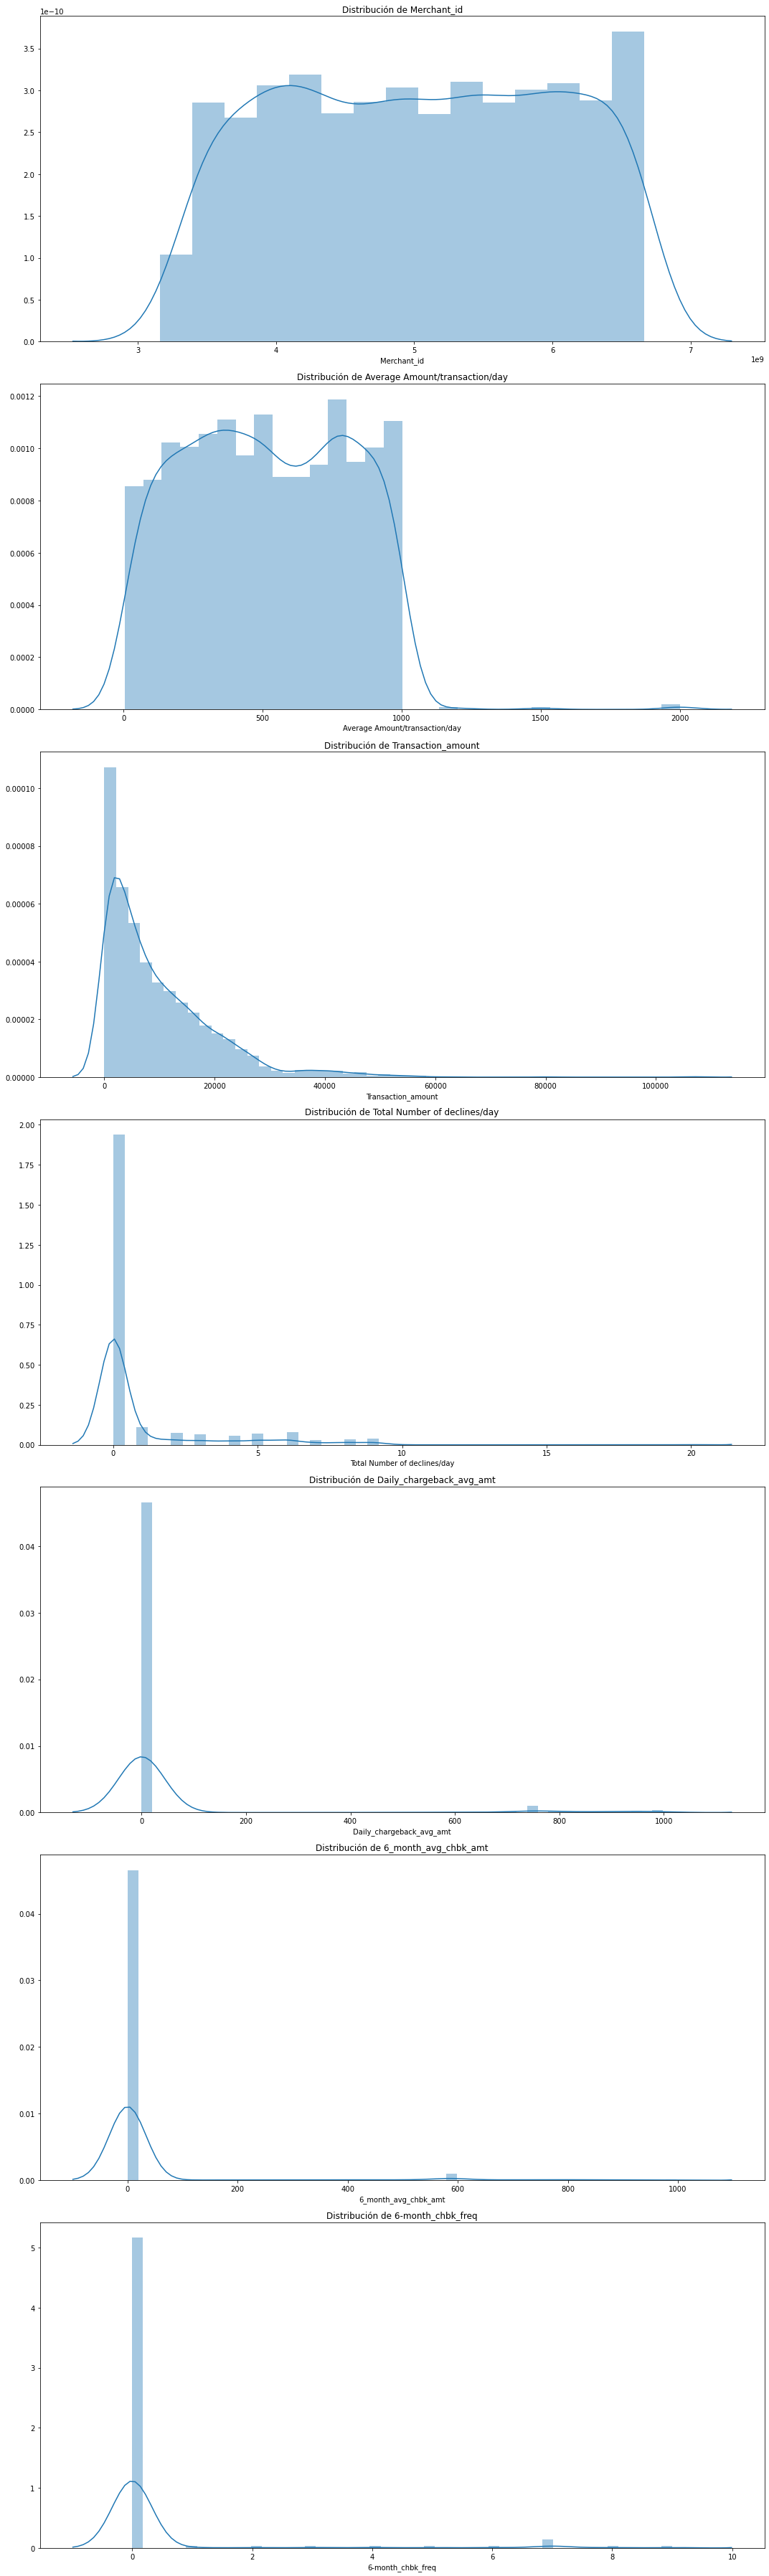

In [27]:
fig, axs = plt.subplots(len(variables_num), 1, figsize=(15, 50))

count = 0
for column in variables_num:
    fp = sb.distplot(data[column], ax=axs[count])
    fp.set_title(f'Distribución de {column}')
    count += 1

plt.tight_layout()

### Distribución de las variables númericas, separando si pertenecen al grupo de fraudulentas o no

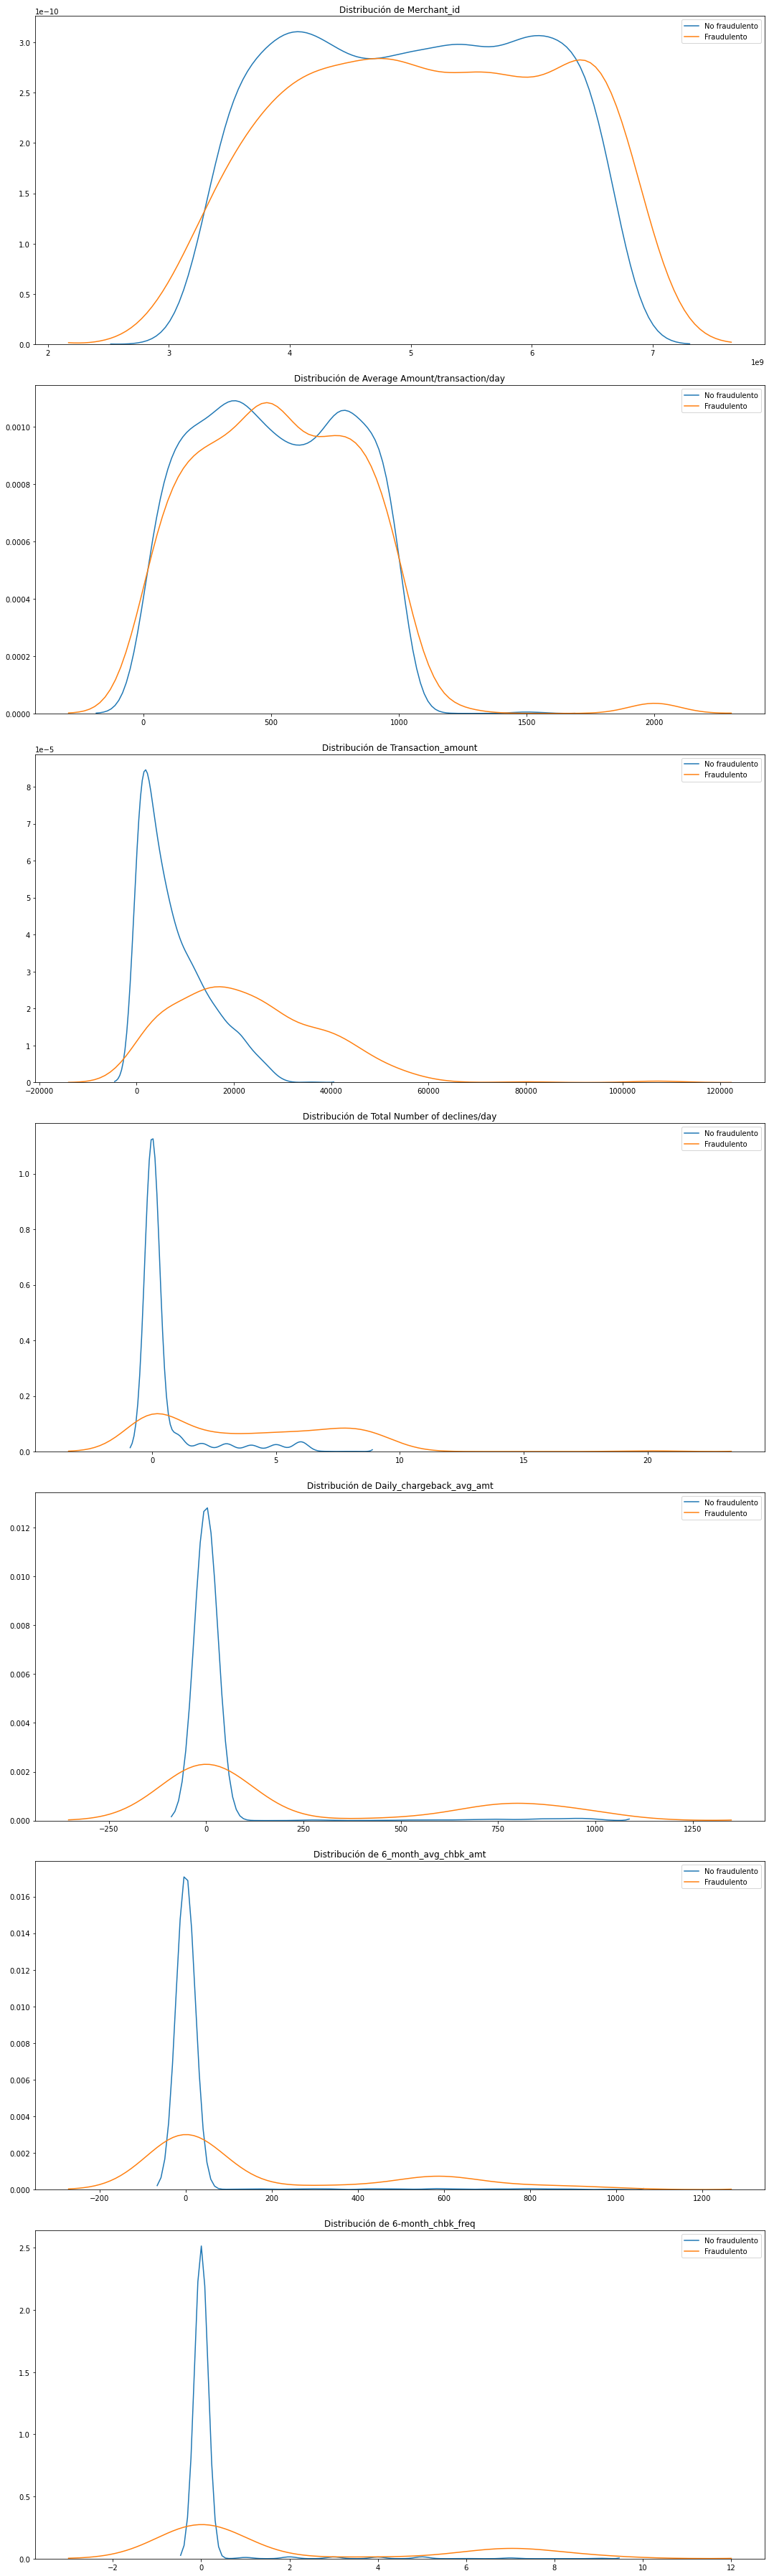

In [47]:
fig, axs = plt.subplots(len(variables_num), 1, figsize=(15, 50))

count = 0
for column in variables_num:
    # No fraudulentas
    sb.kdeplot(
    data[data['isFradulent']=='N'][column],
    ax=axs[count])

    # Faudulentas
    fp = sb.kdeplot(
        data[data['isFradulent']=='Y'][column],
        ax=axs[count])

    fp.legend(['No fraudulento','Fraudulento'])
    fp.set_title(f'Distribución de {column}')
    count += 1

plt.tight_layout()

Añadir una explicación de la distribución para darle un significado.

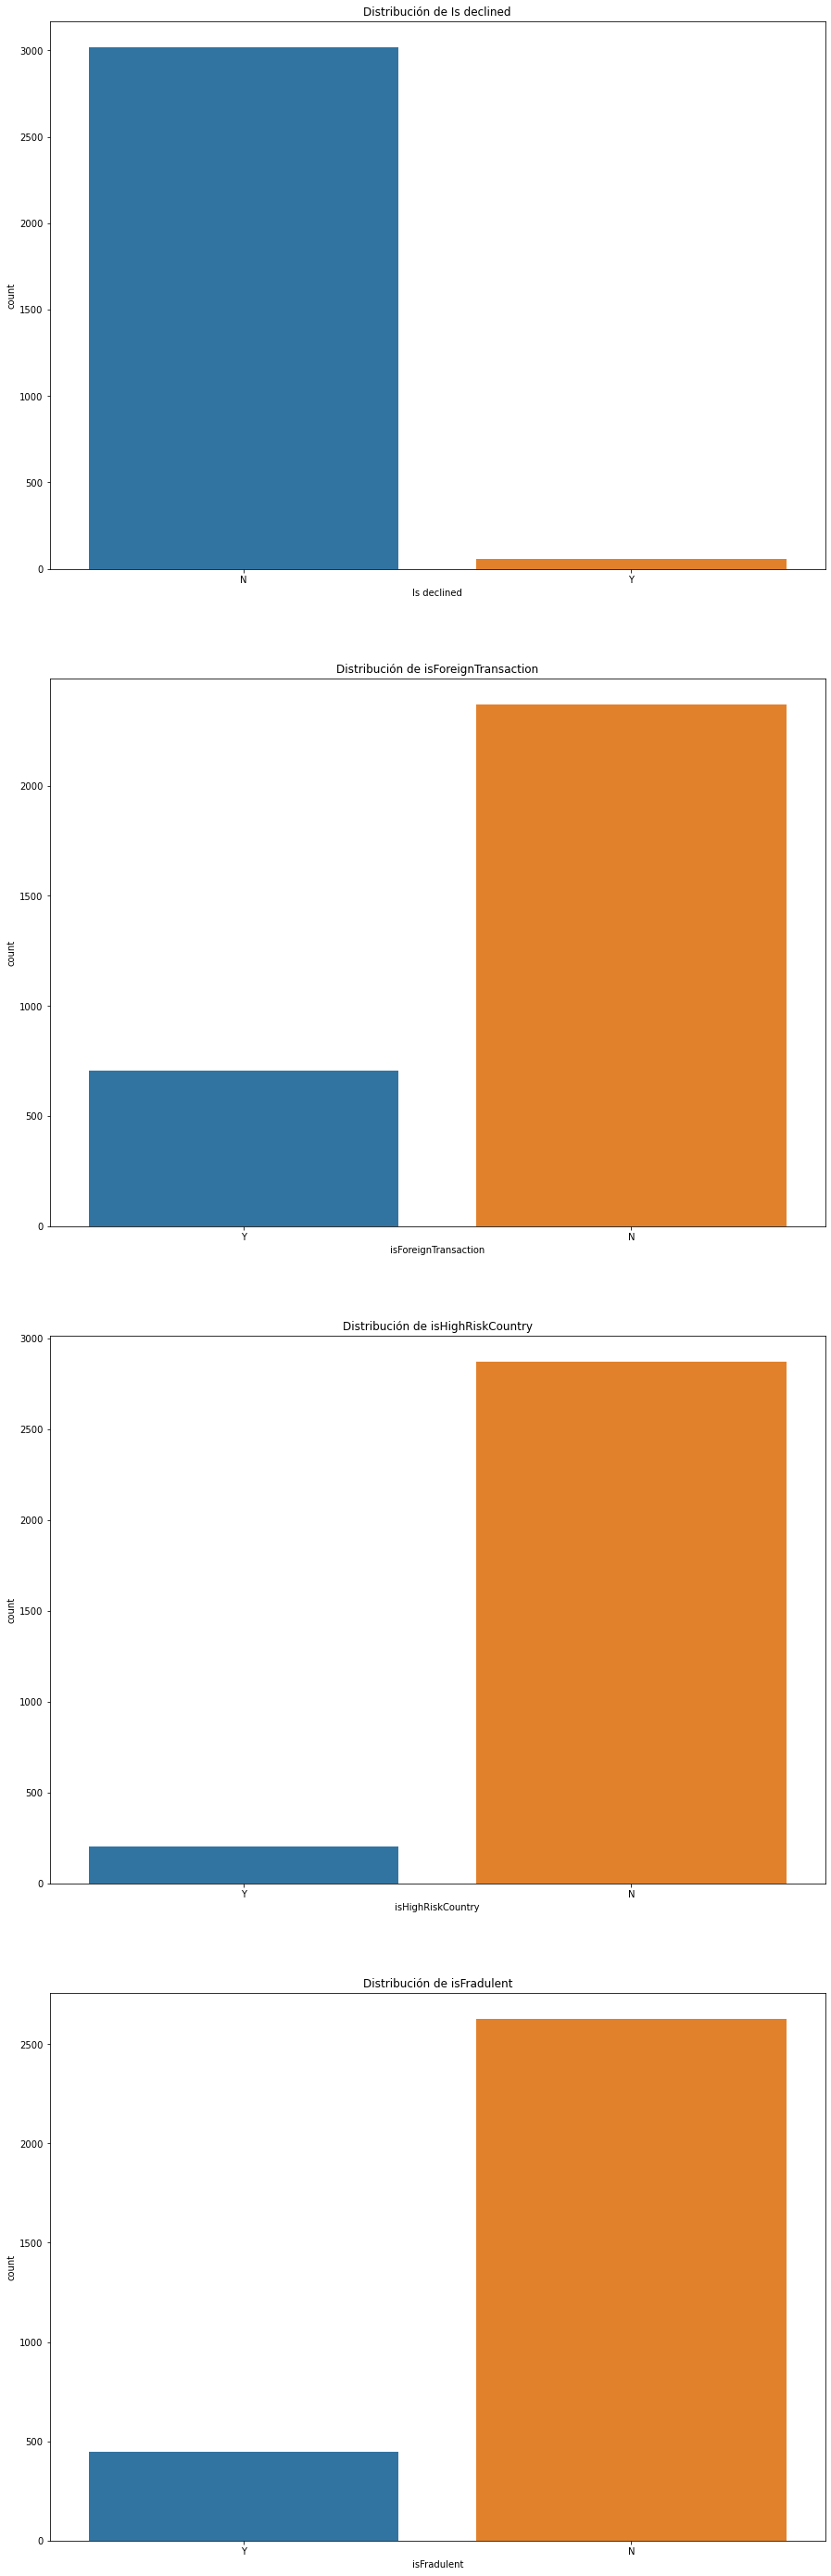

In [28]:
fig, axs = plt.subplots(len(variables_cat), 1, figsize=(15, 50))

count = 0
for column in variables_cat:
    fp = sb.countplot(data[column], ax=axs[count])
    fp.set_title(f'Distribución de {column}')
    fp.set_xticklabels(data[column].unique())
    count += 1

Explicar la gran descompensación de las clases.

### Matriz de correlaciones

Correlaciones superiores al 75%


6_month_avg_chbk_amt  Daily_chargeback_avg_amt    0.953663
6-month_chbk_freq     Daily_chargeback_avg_amt    0.884611
                      6_month_avg_chbk_amt        0.851339
dtype: float64

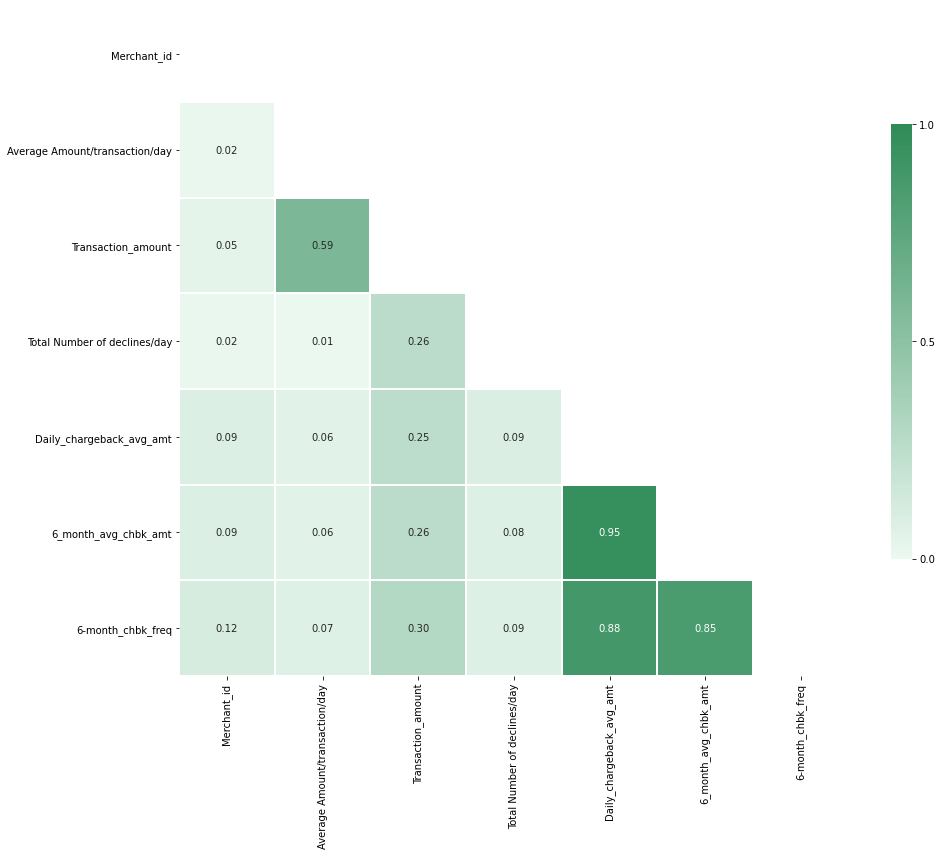

In [31]:
# Calcular correlacion de las variables numericas.
df_matrix_corr = data[variables_num].corr(method='pearson').abs()

# Triangulo inferior de la matrix de correlacion
mask = np.triu(np.ones(df_matrix_corr.shape)).astype(np.bool)

# Grafico de la matriz de correlacion
f, ax = plt.subplots(figsize=(15, 20))
ax.set_yticklabels(df_matrix_corr.columns[1:], rotation=0)
ax.set_xticklabels(df_matrix_corr.columns[:-1], rotation=45)
heatmap = sb.heatmap(
    df_matrix_corr,
    mask=mask,
    square=True,
    linewidths=1,
    cmap=sb.light_palette('seagreen', as_cmap=True),
    cbar_kws={'shrink': .4, 'ticks': [-1, -.5, 0, 0.5, 1]},
    vmin=0,
    vmax=1,
    annot=True,
    annot_kws={"size": 10},
    fmt=".2f"
)

print('Correlaciones superiores al 75%')
corr_unstack = df_matrix_corr.unstack()
corr_unstack[(corr_unstack>=0.75) & (corr_unstack<1)].sort_values(kind="quicksort", ascending=False).drop_duplicates()

Explicación de las correlaciones y que vairables se deberían eliminar.

In [36]:
# Eliminar las columnas que se deban eliminar
#data = data.drop(columns=[])

### Tratamiento de datos faltantes

In [35]:
data = data.replace([np.inf, -np.inf], np.nan)
data.isna().sum()[data.isna().sum() > 0] / len(data) * 100

Series([], dtype: float64)

Todas la variables están completas, ninguna presenta muestras faltantes. No se aplica ningún tratamiento por tanto.

## Isolation Forest

### Preprocesado

Se convierten las variables categoricas en label enconding. Se distinge entre variables inlier y outliers. Se utiliza hold out para entrenar el modelo mediante los inliers.

In [50]:
for variable in variables_cat:
    data[variable]= data[variable].replace('N',0)
    data[variable]=data[variable].replace('Y',1)
data.head(5)

,Merchant_id,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,100.0,3000.0,0,5,1,1,0,0.0,0,1
1,3160040998,100.0,4300.0,0,5,1,1,0,0.0,0,1
2,3160041896,185.5,4823.0,1,5,0,0,0,0.0,0,1
3,3160141996,185.5,5008.5,1,8,0,0,0,0.0,0,1
4,3160241992,500.0,26000.0,0,0,1,1,800,677.2,6,1


In [57]:
x = data[data.isFradulent == 0]
outliers = data[data.isFradulent == 1]
x_train, x_test = train_test_split(x, test_size=0.1, random_state=42)


### Modelo

In [115]:
clf = IsolationForest(max_samples=100, random_state=42)
clf.fit(x_train)
pred_inliers = clf.predict(x_test)
pred_outliers = clf.predict(outliers)

print(f'Inliers:\n{pred_inliers}')
pred_inliers_ok = len(list(filter(lambda x: x == 1, pred_inliers)))
print(f'Se han predecido correctamente el {(pred_inliers_ok / len(outliers)) * 100:.2f}% de los inliers.\n')
print(f'Outliers:\n{pred_outliers}')
num_pred_corectamente = len(list(filter(lambda x: x == -1, pred_outliers)))
print(f'Se han predecido correctamente el {(num_pred_corectamente / len(outliers)) * 100:.2f}% de los outliers.')
# Es necesario divir en xtrain y x_test realmente ¿?


Inliers:
[ 1  1  1 -1  1  1  1  1  1  1  1  1 -1  1 -1  1 -1  1  1  1  1  1 -1 -1
  1 -1 -1  1  1  1  1  1  1  1 -1  1  1 -1  1  1 -1  1  1  1  1  1  1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1 -1 -1  1  1  1 -1 -1  1  1  1 -1  1  1
  1 -1  1  1  1  1  1 -1  1 -1  1 -1  1  1  1 -1  1 -1  1  1  1  1  1  1
  1  1  1  1 -1 -1  1  1 -1 -1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1
  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1 -1  1 -1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1  1 -1  1 -1
  1  1  1  1  1  1 -1  1  1  1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1  1
 -1  1  1  1  1  1  1 -1  1 -1  1  1  1 -1  1  1  1  1  1  1  1 -1  1]
Se han predecido correctamente el 46.43% de los inliers.

Outliers:
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 

In [ ]:
# https://towardsdatascience.com/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2
# Aplicar visualización de los resultados.

## K-means o One-class SVM

In [116]:
from sklearn.svm import OneClassSVM
clf = OneClassSVM(gamma='auto').fit(x_train)
pred_inliers = clf.predict(x_test)
pred_outliers = clf.predict(outliers)

print(f'Inliers:\n{pred_inliers}')
pred_inliers_ok = len(list(filter(lambda x: x == 1, pred_inliers)))
print(f'Se han predecido correctamente el {(pred_inliers_ok / len(outliers)) * 100:.2f}% de los inliers.\n')
print(f'Outliers:\n{pred_outliers}')
num_pred_corectamente = len(list(filter(lambda x: x == -1, pred_outliers)))
print(f'Se han predecido correctamente el {(num_pred_corectamente / len(outliers)) * 100:.2f}% de los outliers.')


Inliers:
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Se han predecido correctamente el 0.00% de los inliers.

Outliers:
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -